In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import journal_figure
from scipy.stats import spearmanr
import json
from utils import get_gt_single

In [2]:
import h5py

with h5py.File('coco_indices_in_python.mat', 'r') as f:
    print(list(f.keys()))  #
    indices_coco = f['coco_indices_in_python'][:]

indices_coco = np.array(indices_coco.squeeze(), dtype=int)

['coco_indices_in_python']


In [3]:
all_models = ["resnet18", "alexnet", "convnext", "vgg19", "resnet50", "vgg16", "vit", "vit_ssl", "resnet_ssl", "efficientnet", "swin"]

In [4]:
selected_indices = [0, 2, 22, 25, 41, 44, 63, 68, 81, 85, 101, 120, 122, 140, 142, 161, 180, 187]
selected_indices_v2 = [8, 18, 24, 31, 46, 54, 70, 76, 86, 87, 102, 103, 105, 123, 130, 143, 144, 163, 172, 173, 191, 199]
all_selected_indices = list(sorted(selected_indices + selected_indices_v2))

no40 = ~np.isin(np.arange(len(indices_coco)), all_selected_indices)
indices_no40 = np.arange(len(indices_coco))[no40]

all_split1 = []
all_split2 = []
for r in range(20):
    indices = np.random.choice(160, 80, replace=False)
    split1 = indices_no40[indices]
    split2 = np.setdiff1d(indices_no40, split1)

    all_split1.append(list(sorted(split1)))
    all_split2.append(list(sorted(split2)))

In [5]:
best_ref_pemi_clean_scores = {}
best_ref_pemi_clean = {}
    
for target_model_name in all_models:
    score_accross_reps = []
    for r in range(20):
        clean_corrs = []
        i1_clean_target = np.load(f"./i1s_clean/i1_{target_model_name}.npy")[all_split1[r]]
        for ref_model_name in all_models:
            i1_clean_ref = np.load(f"./i1s_clean/i1_{ref_model_name}.npy")[all_split1[r]]
            if ref_model_name == target_model_name:
                clean_corrs.append(np.nan)
            else:
                clean_corrs.append(spearmanr(i1_clean_target, i1_clean_ref)[0])
        score_accross_reps.append(clean_corrs)

    score_accross_reps = np.array(score_accross_reps)
    
    score_accross_reps = np.nanmean(score_accross_reps, axis=0)
    best_ref_pemi_clean_score = np.nanmax(score_accross_reps)
            
    best_ref_pemi_clean_scores[target_model_name] = best_ref_pemi_clean_score
    best_ref_pemi_clean[target_model_name] = all_models[np.nanargmax(score_accross_reps)]

/var/folders/h2/8tj3snsd0wj1qzvdlg5_17y00000gn/T/ipykernel_85949/1441377816.py:19: RuntimeWarning: Mean of empty slice
  score_accross_reps = np.nanmean(score_accross_reps, axis=0)


In [6]:
best_ref_pemi_clean_scores_test = {}
best_ref_pemi_clean_errors_test = {}
for target_model_name in all_models:
    clean_corrs = []
    for r in range(20):
        
        i1_clean_target = np.load(f"./i1s_clean/i1_{target_model_name}.npy")[all_split2[r]]
        i1_clean_ref = np.load(f"./i1s_clean/i1_{best_ref_pemi_clean[target_model_name]}.npy")[all_split2[r]]
        corr = spearmanr(i1_clean_target, i1_clean_ref)[0]
        clean_corrs.append(corr)
    best_ref_pemi_clean_scores_test[target_model_name] = np.nanmean(np.array(clean_corrs))
    best_ref_pemi_clean_errors_test[target_model_name] = np.nanstd(np.array(clean_corrs))

In [14]:
emis_colors = list(reversed(['#590d22', '#800f2f', '#a4133c', '#c9184a', '#ff4d6d', '#ff617e', '#ff758f', '#ff8fa3', '#ffb3c1', '#ffccd5', '#fff0f3']))


In [8]:
method_names = ['Saliency', 'NoiseTunnel_Saliency', 'Deconvolution', 'InputXGradient', 'GuidedBackprop', 'GradientShap', 'Occlusion', 'IntegratedGradients', 'NoiseTunnel_Deconvolution', 'NoiseTunnel_InputXGradient', 'FeatureAblation', 'FeaturePermutation']

In [10]:
from six.moves import cPickle as pickle 

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        ret_di = pickle.load(f)
    return ret_di

all_similarities = load_dict('./all_similarities.pkl')

In [16]:
percentiles = [50, 60, 65, 70, 75, 80, 85, 90, 95, 97, 98, 99]

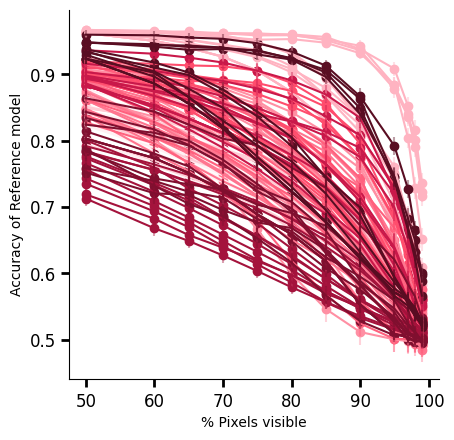

In [23]:
for t, ref_model_name in enumerate(all_models):
    
    for m, method_name in enumerate(method_names):
        temp_p = []
        for p in percentiles:        
            response_dir = f'../../XAI/behavioral_responses_v2/{ref_model_name}/{method_name}'
        
            i1_file_ref_pemi = f'{response_dir}/{p}/{ref_model_name}_i1.json'
            
            with open(i1_file_ref_pemi, 'r') as f:
                i1_scores_ref_pemi = json.load(f)
            i1_ref = np.array(i1_scores_ref_pemi['target_pEMI'])
            temp_p.append(i1_ref.mean())
            
            plt.scatter(p, i1_ref.mean(), color=emis_colors[t])
            plt.errorbar(p, i1_ref.mean(), yerr=i1_ref.std()/np.sqrt(200), color=emis_colors[t], alpha=0.4)
        plt.plot(percentiles, temp_p, color=emis_colors[t])

plt.ylabel('Accuracy of Reference model')
plt.xlabel('% Pixels visible')
journal_figure()

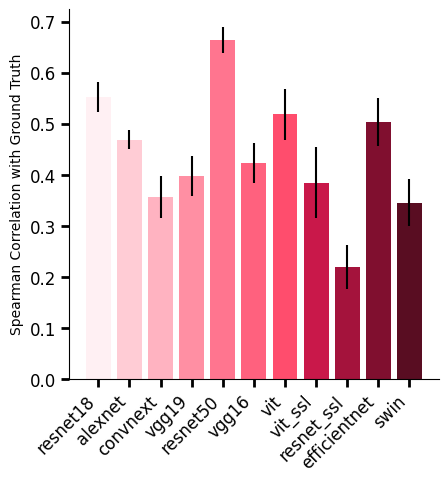

In [17]:
res = np.zeros((len(all_models), 20, 12))
errors = np.zeros((len(all_models), 20, 12))

for t, target_model_name in enumerate(all_models):
    ref_model_name = best_ref_pemi_clean[target_model_name]
    i1_clean_ref = np.load(f"./i1s_clean/i1_{ref_model_name}.npy")
    i1_clean_target = np.load(f"./i1s_clean/i1_{target_model_name}.npy")
    for r in range(20):
        
        gt_ref = get_gt_single(target_model_name, ref_model_name, all_similarities, method_names)[:, all_split2[r]]
        gt_ref = gt_ref.mean(axis=1)
        # print(len(gt_ref))

        for p_idx, p in enumerate(percentiles):
            temp_p = []
            for m, method_name in enumerate(method_names):
                
                response_dir = f'../../XAI/behavioral_responses_v2/{ref_model_name}/{method_name}'
                
                i1_file_target_pemi = f'{response_dir}/{p}/{target_model_name}_i1.json'
                i1_file_ref_pemi = f'{response_dir}/{p}/{ref_model_name}_i1.json'
                
                with open(i1_file_target_pemi, 'r') as f:
                    i1_scores_target_pemi = json.load(f)
                with open(i1_file_ref_pemi, 'r') as f:
                    i1_scores_ref_pemi = json.load(f)

                i1_target = np.array(i1_scores_target_pemi['target_pEMI'])[all_split2[r]]
                i1_ref = np.array(i1_scores_ref_pemi['target_pEMI'])[all_split2[r]]

                corr_pemi = spearmanr(i1_target, i1_ref)[0]
                
                temp_p.append(corr_pemi)

            corr = spearmanr(temp_p, gt_ref)[0]
            res[t, r, p_idx] = corr

    avg_corr = np.median(res[t], axis=0)
    std_corr = res[t].std(axis=0)
    best_corr = np.max(avg_corr)
    best_p_idx = np.argmax(avg_corr)
    best_err = std_corr[best_p_idx]
    plt.bar(t, best_corr, yerr=(best_err)/np.sqrt(20), color=emis_colors[t]) #/spearmanr(i1_clean_target, i1_clean_ref)[0]

plt.xticks(range(len(all_models)), all_models, rotation=45, ha='right')
plt.ylabel('Spearman Correlation with Ground Truth')
journal_figure()